In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime as dt
from functools import partial, wraps

from plasticc.featurize import process_meta, featurize
from plasticc.training import path_from_cv_score, train_and_validate
from plasticc.final import featurize_test, predict_test

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis' : None, 
        'skewness' : None,
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [21]:
aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum', 'skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

### Generate features for model training

In [22]:
%%time
meta_train = process_meta('../../data/raw/training_set_metadata.csv')
train = pd.read_csv('../../data/raw/training_set.csv')

CPU times: user 1.32 s, sys: 88 ms, total: 1.41 s
Wall time: 928 ms


In [23]:
%%time
X = featurize(train, meta_train, aggs, fcp, n_jobs=4)

Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 15.67it/s]


CPU times: user 1min 1s, sys: 1.72 s, total: 1min 2s
Wall time: 29.6 s


In [24]:
if 'target' in X:
    y = X['target']
    del X['target']
else:
    print("What the duck")
    3//0

In [25]:
%%time
train_mean = X.mean(axis=0)
#train_mean.to_hdf('train_data.hdf5', 'data')
# pd.set_option('display.max_rows', 500)
#import pdb; pdb.set_trace()
X.fillna(0, inplace=True)

CPU times: user 136 ms, sys: 4 ms, total: 140 ms
Wall time: 6.93 ms


In [26]:
X = X.replace([np.inf, -np.inf], np.nan)
[col for col in X.columns if X[col].isna().any()]

[]

### Generating polynomial features

In [27]:
X_backup = X.copy()

In [28]:
non_id_cols = [col for col in X.columns if not col == 'object_id']

In [29]:
scaler = MinMaxScaler(feature_range=(0,1))

In [30]:
scaled = scaler.fit_transform(X[non_id_cols].values)

In [33]:
poly = PolynomialFeatures(degree=3)

In [34]:
%%time
poly_features = poly.fit_transform(scaled)

CPU times: user 9.22 s, sys: 4.44 s, total: 13.7 s
Wall time: 13.7 s


In [35]:
poly_df = pd.DataFrame(poly_features, index=X['object_id'], columns=[f'Poly_{fnum}' for fnum in range(poly_features.shape[1])])

In [36]:
poly_select = pd.DataFrame({'var': poly_df.var(), 'mean': poly_df.mean(), 'std': poly_df.std()})

In [37]:
poly_select['cv'] = poly_select['std'] / poly_select['mean'].abs()

In [38]:
sorted_select = poly_select.sort_values(by='cv', ascending=False)

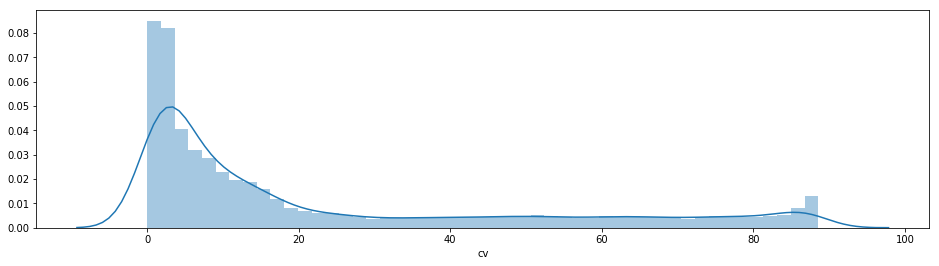

In [39]:
_, ax = plt.subplots(figsize=(16,4))
sns.distplot(sorted_select['cv'], ax=ax)
plt.show()

In [45]:
len(sorted_select[sorted_select['cv'] > 88.4])

107

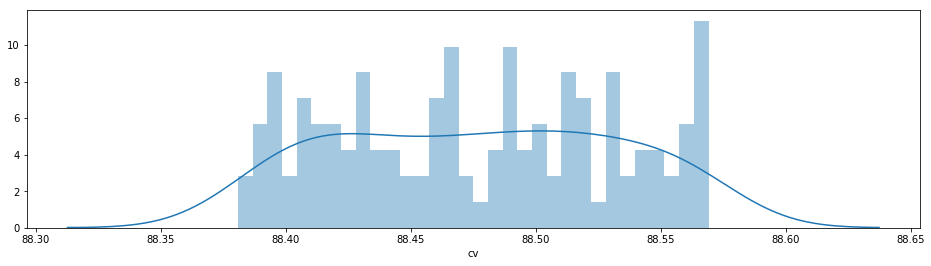

In [47]:
_, ax = plt.subplots(figsize=(16,4))
sns.distplot(sorted_select['cv'].head(120), ax=ax, bins=32)
plt.show()

In [48]:
len(sorted_select[sorted_select['cv'] > 88.4])

107

##### This looks like a good starting point (not too much features)

In [49]:
select_cols = list((sorted_select[sorted_select['cv'] > 88.4]).index)

In [50]:
X = X.join(poly_df[select_cols], on='object_id')

In [51]:
X.shape

(7848, 176)

In [52]:
y.shape

(7848,)

### Train model with CV

In [53]:
lgbm_params = {
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': 16,
    'max_depth': 6,
    'n_estimators': 2048,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.5,
    'drop_rate': 0.173,
    'learning_rate': 0.0267,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 0.126,
    'num_leaves': 7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75,
    'max_bin': 32,
    'min_data_in_leaf': 13,
    'lambda_l1': 2,
}

model_params = {
    'lgbm': lgbm_params,
}

In [54]:
# update best params for lgbm to account for more features
lgbm_params.update({
    'boosting_type': 'dart',
#     'learning_rate': 0.033,
    'n_estimators': 2048,
    'max_bin': 64,
#     'num_leaves': 11,
#     'min_data_in_leaf': 32,
#     'min_sum_hessian_in_leaf': 0,
#     'bagging_fraction': 0,
#     'bagging_freq': 0,
#     'feature_fraction': 0.75,
#     'min_gain_to_split': 50.,
    'max_depth': 9,
})

In [55]:
colnames_to_ignore = set([
    'object_id',
    'hostgal_specz',
    'ra',
    'decl',
    'gal_l',
    'gal_b',
    'ddf'
])
feature_colnames = [col for col in X.columns if col not in colnames_to_ignore]
id_colname = 'object_id'

In [56]:
%%time
# modeling from CV
clfs, score, importances = train_and_validate(
    X=X, 
    y=y, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params=model_params,
    nr_fold=5, 
    random_state=1
)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.986066	training's wloss: 1.39824	valid_1's multi_logloss: 2.03443	valid_1's wloss: 1.54516
[200]	training's multi_logloss: 0.596732	training's wloss: 1.00166	valid_1's multi_logloss: 1.69241	valid_1's wloss: 1.19768
[300]	training's multi_logloss: 0.385449	training's wloss: 0.804435	valid_1's multi_logloss: 1.56727	valid_1's wloss: 1.02346
[400]	training's multi_logloss: 0.282704	training's wloss: 0.682416	valid_1's multi_logloss: 1.46458	valid_1's wloss: 0.91957
[500]	training's multi_logloss: 0.218615	training's wloss: 0.598769	valid_1's multi_logloss: 1.39547	valid_1's wloss: 0.851384
[600]	training's multi_logloss: 0.190209	training's wloss: 0.545329	valid_1's multi_logloss: 1.32379	valid_1's wloss: 0.810512
[700]	training's multi_logloss: 0.161253	training's wloss: 0.493982	valid_1's multi_logloss: 1.26852	valid_1's wloss: 0.774698
[800]	training's multi_logloss: 0.142254	training's wl

In [57]:
sorted_importances = importances.sort_values(by='mean_gain', ascending=False)

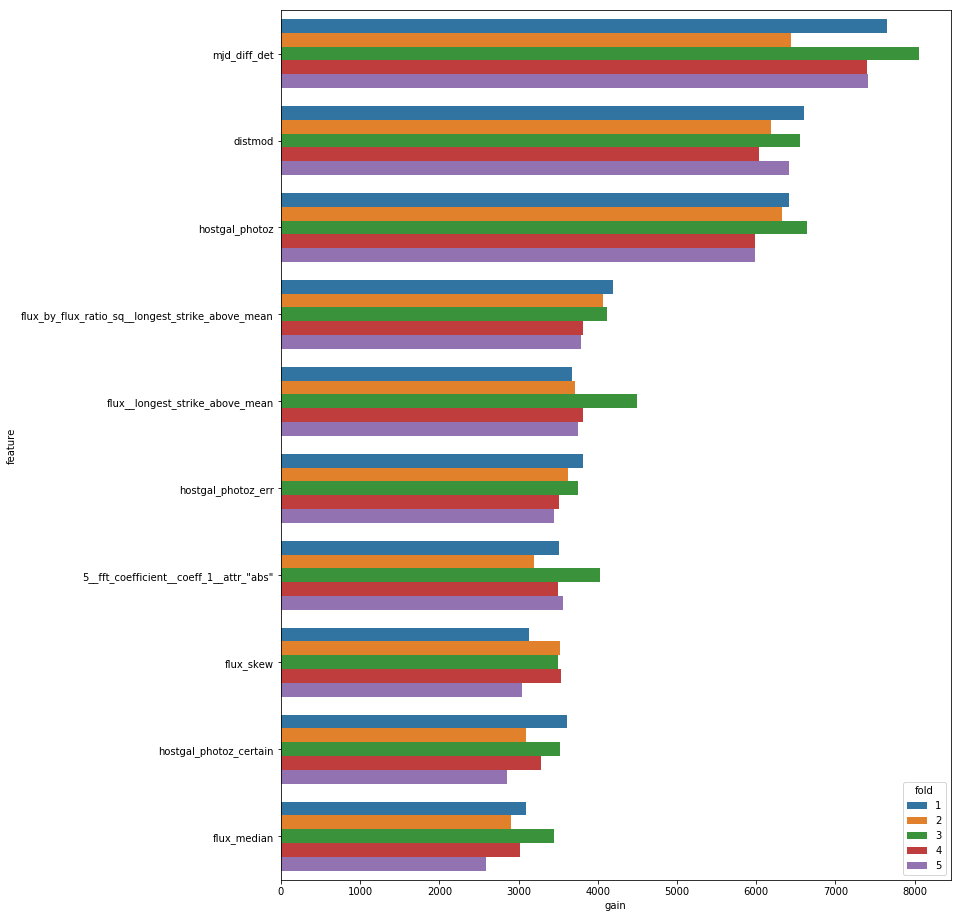

In [58]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=sorted_importances.head(50), x='gain', y='feature', hue='fold', )
plt.show()

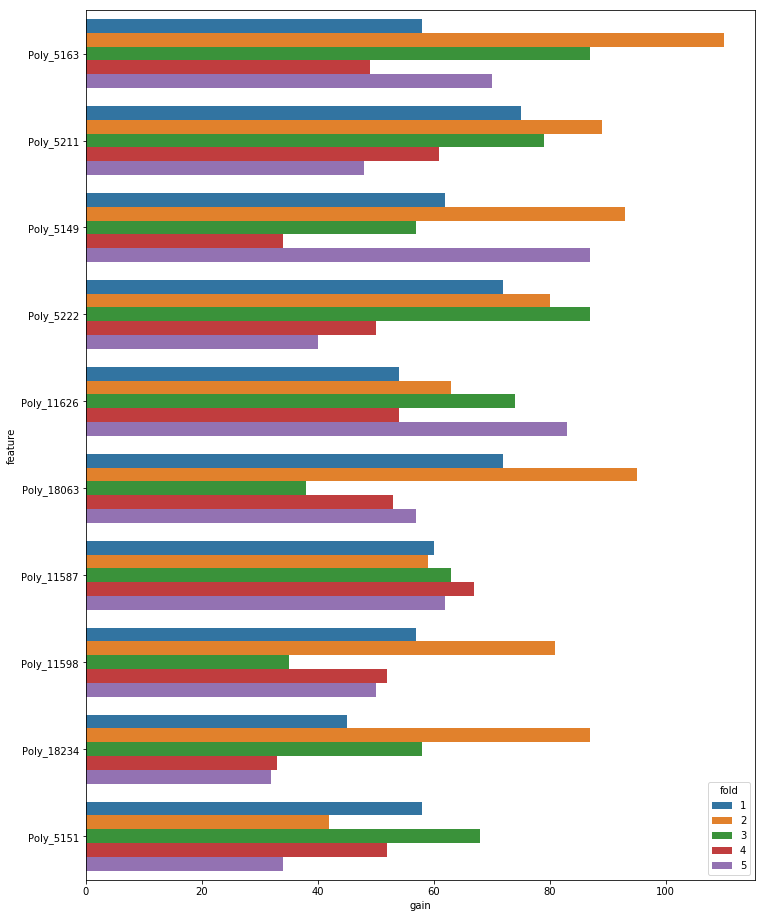

In [59]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=sorted_importances.tail(50), x='gain', y='feature', hue='fold', )
plt.show()

In [60]:
submission_file_path = path_from_cv_score(score)
submission_file_path

'/home/kk385830/astronomical-classification/submissions/subm_0.652449_2018-12-13-22-58.csv'

### PCA

In [72]:
from sklearn.decomposition import PCA

In [73]:
pca = PCA(n_components=len(poly_df)//100)

In [74]:
%%time
poly_pca = pca.fit_transform(poly_df.values)

CPU times: user 2min 28s, sys: 24.9 s, total: 2min 53s
Wall time: 20.1 s


In [75]:
poly_pca.shape

(7848, 78)

##### Repeat steps performed on cv-based selection of features to compare these strategies

In [76]:
pca_df = pd.DataFrame(poly_pca, index=X['object_id'], columns=[f'Poly_{fnum}' for fnum in range(poly_pca.shape[1])])

In [78]:
poly_select = pd.DataFrame({'var': pca_df.var(), 'mean': pca_df.mean(), 'std': pca_df.std()})

In [79]:
poly_select['cv'] = poly_select['std'] / poly_select['mean'].abs()

In [80]:
sorted_select = poly_select.sort_values(by='cv', ascending=False)

In [82]:
sorted_select.head()

,var,mean,std,cv
Poly_36,0.194770,2.010228e-17,0.441328,2.195412e+16
Poly_11,1.211780,-5.123889e-17,1.100809,2.148385e+16
Poly_4,6.591387,-1.800859e-16,2.567370,1.425636e+16
Poly_14,0.855567,-9.152833e-17,0.924969,1.010582e+16
Poly_2,9.925041,3.284834e-16,3.150403,9.590753e+15


In [83]:
sorted_select.tail()

,var,mean,std,cv
Poly_58,0.071906,-6.990246e-16,0.268154,3.836112e+14
Poly_54,0.084909,-7.760845e-16,0.291391,3.754628e+14
Poly_50,0.093169,-8.583362e-16,0.305236,3.556133e+14
Poly_48,0.102862,9.081569e-16,0.320720,3.531552e+14
Poly_71,0.047521,-6.528360e-16,0.217993,3.339170e+14


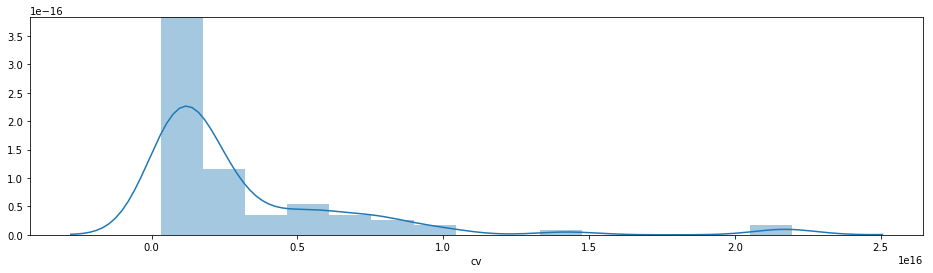

In [81]:
_, ax = plt.subplots(figsize=(16,4))
sns.distplot(sorted_select['cv'], ax=ax)
plt.show()

##### This looks like a good starting point (not too much features)

In [84]:
X = X.join(pca_df, on='object_id')

In [85]:
X.shape

(7848, 254)

In [86]:
y.shape

(7848,)

### Perform training once again

In [87]:
colnames_to_ignore = set([
    'object_id',
    'hostgal_specz',
    'ra',
    'decl',
    'gal_l',
    'gal_b',
    'ddf'
])
feature_colnames = [col for col in X.columns if col not in colnames_to_ignore]
id_colname = 'object_id'

In [88]:
%%time
# modeling from CV
pca_clfs, pca_score, pca_importances = train_and_validate(
    X=X, 
    y=y, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params=model_params,
    nr_fold=5, 
    random_state=1
)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.97171	training's wloss: 1.36991	valid_1's multi_logloss: 2.01179	valid_1's wloss: 1.53378
[200]	training's multi_logloss: 0.586278	training's wloss: 0.97424	valid_1's multi_logloss: 1.6744	valid_1's wloss: 1.19135
[300]	training's multi_logloss: 0.375754	training's wloss: 0.780485	valid_1's multi_logloss: 1.55285	valid_1's wloss: 1.01779
[400]	training's multi_logloss: 0.271726	training's wloss: 0.659488	valid_1's multi_logloss: 1.44869	valid_1's wloss: 0.912656
[500]	training's multi_logloss: 0.207008	training's wloss: 0.574763	valid_1's multi_logloss: 1.37641	valid_1's wloss: 0.839984
[600]	training's multi_logloss: 0.179335	training's wloss: 0.522554	valid_1's multi_logloss: 1.30464	valid_1's wloss: 0.801067
[700]	training's multi_logloss: 0.150371	training's wloss: 0.469558	valid_1's multi_logloss: 1.24676	valid_1's wloss: 0.763521
[800]	training's multi_logloss: 0.131664	training's wlo

In [89]:
sorted_importances = pca_importances.sort_values(by='mean_gain', ascending=False)

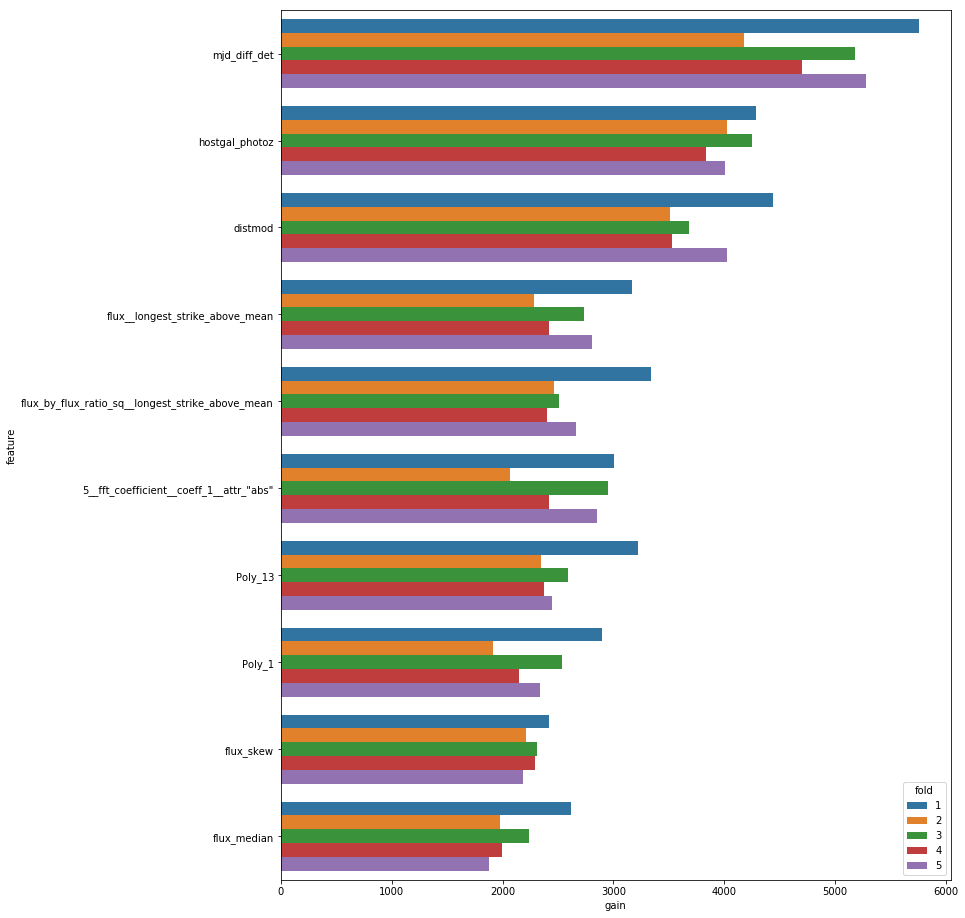

In [90]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=sorted_importances.head(50), x='gain', y='feature', hue='fold', )
plt.show()

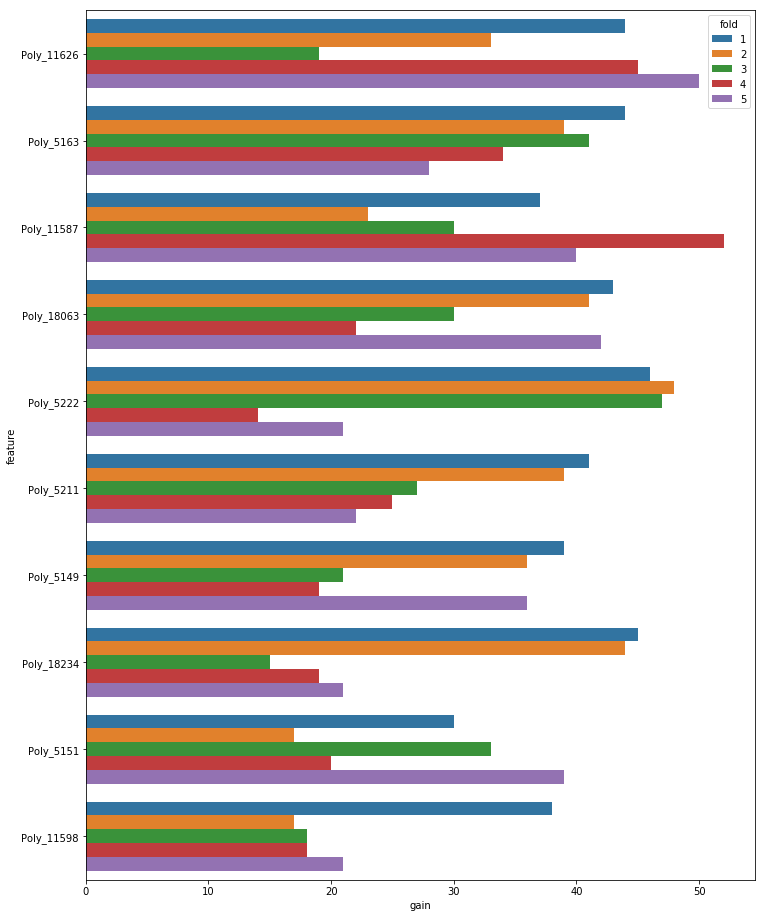

In [91]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=sorted_importances.tail(50), x='gain', y='feature', hue='fold', )
plt.show()

In [92]:
pca_submission_file_path = path_from_cv_score(pca_score)
pca_submission_file_path

'/home/kk385830/astronomical-classification/submissions/subm_0.655417_2018-12-14-00-35.csv'

### Test set features

In [61]:
chunk_size_one_100 = 453653105 // 100 + 1
# chunk_size_one_100 = 1000001 // 100 + 1
chunk_size_one_100

4536532

In [ ]:
featurized_set_savior = 2//3  # to prevent accidental running
%%time
# should take 100x (time after 1st iteration)
featurize_test(
    featurize_configs={'aggs': aggs, 'fcp': fcp}, 
    n_jobs=12,
    meta_path='../data/raw/test_set_metadata.csv',
    test_path='../data/raw/test_set.csv',
    output_path='../data/features/test-all-feat-from-kernel-repro.csv',
    id_colname='object_id',
    chunks=chunk_size_one_100,  # alternatively: 5000000
)

Feature Extraction: 100%|██████████| 60/60 [00:01<00:00, 37.97it/s]


        4536532 done in   1.0 minutes


Feature Extraction: 100%|██████████| 60/60 [00:01<00:00, 38.33it/s]


        9073064 done in   1.9 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 18.97it/s]


       13609596 done in   3.4 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.12it/s]


       18146128 done in   5.4 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.09it/s]


       22682660 done in   7.3 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.16it/s]


       27219192 done in   9.3 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.16it/s]


       31755724 done in  11.2 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.69it/s]


       36292256 done in  13.1 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.10it/s]


       40828788 done in  15.0 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 15.10it/s]


       45365320 done in  16.9 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.35it/s]


       49901852 done in  18.8 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 10.89it/s]


       54438384 done in  20.7 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.96it/s]


       58974916 done in  22.6 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.82it/s]


       63511448 done in  24.5 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.12it/s]


       68047980 done in  26.4 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.20it/s]


       72584512 done in  28.3 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.68it/s]


       77121044 done in  30.1 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.58it/s]


       81657576 done in  32.0 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 16.41it/s]


       86194108 done in  33.9 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.39it/s]


       90730640 done in  35.8 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.05it/s]


       95267172 done in  37.7 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 15.90it/s]


       99803704 done in  39.6 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.55it/s]


      104340236 done in  41.5 minutes


Feature Extraction: 100%|██████████| 60/60 [00:05<00:00, 11.84it/s]


      108876768 done in  43.3 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.73it/s]


      113413300 done in  45.2 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 15.18it/s]


      117949832 done in  47.1 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.39it/s]


      122486364 done in  49.0 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.35it/s]


      127022896 done in  50.9 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.31it/s]


      131559428 done in  52.7 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.50it/s]


      136095960 done in  54.5 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.33it/s]


      140632492 done in  56.3 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 16.84it/s]


      145169024 done in  58.1 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.65it/s]


      149705556 done in  59.9 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 16.09it/s]


      154242088 done in  61.7 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.59it/s]


      158778620 done in  63.6 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.99it/s]


      163315152 done in  65.4 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.77it/s]


      167851684 done in  67.2 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 15.79it/s]


      172388216 done in  69.1 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.45it/s]


      176924748 done in  70.9 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.92it/s]


      181461280 done in  72.7 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.61it/s]


      185997812 done in  74.5 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 11.11it/s]


      190534344 done in  76.3 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.95it/s]


      195070876 done in  78.1 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.54it/s]


      199607408 done in  79.9 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 16.57it/s]


      204143940 done in  81.8 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.56it/s]


      208680472 done in  83.6 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.91it/s]


      213217004 done in  85.4 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.19it/s]


      217753536 done in  87.2 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.10it/s]


      222290068 done in  89.0 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.89it/s]


      226826600 done in  90.9 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.21it/s]


      231363132 done in  92.7 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.79it/s]


      235899664 done in  94.5 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.66it/s]


      240436196 done in  96.3 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 19.90it/s]


      244972728 done in  98.2 minutes


Feature Extraction: 100%|██████████| 60/60 [00:05<00:00, 11.71it/s]


      249509260 done in 100.0 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.04it/s]


      254045792 done in 101.8 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 16.25it/s]


      258582324 done in 103.6 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.43it/s]


      263118856 done in 105.4 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.43it/s]


      267655388 done in 107.2 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 16.07it/s]


      272191920 done in 109.0 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.52it/s]


      276728452 done in 110.9 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.01it/s]


      281264984 done in 112.7 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 18.15it/s]


      285801516 done in 114.5 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 15.81it/s]


      290338048 done in 116.4 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.57it/s]


      294874580 done in 118.2 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.56it/s]


      299411112 done in 120.0 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 13.52it/s]


      303947644 done in 121.8 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 20.45it/s]


      308484176 done in 123.6 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 12.44it/s]


      313020708 done in 125.4 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.05it/s]


      317557240 done in 127.2 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.35it/s]


      322093772 done in 129.0 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 15.36it/s]


      326630304 done in 130.8 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 16.76it/s]


      331166836 done in 132.6 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 17.84it/s]


      335703368 done in 134.3 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.28it/s]


      340239900 done in 136.1 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 16.64it/s]


      344776432 done in 137.9 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.33it/s]


      349312964 done in 139.6 minutes


Feature Extraction: 100%|██████████| 60/60 [00:04<00:00, 14.89it/s]


      353849496 done in 141.4 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.46it/s]


      358386028 done in 143.2 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.05it/s]


      362922560 done in 145.0 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.53it/s]


      367459092 done in 146.8 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 15.05it/s]


      371995624 done in 148.6 minutes


Feature Extraction: 100%|██████████| 60/60 [00:03<00:00, 17.05it/s]


      376532156 done in 150.3 minutes


### Test set predictions

In [20]:
%%time
submission = predict_test(
    clfs=clfs, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    input_path='../data/features/test-all-feat-from-kernel-repro.csv', 
    output_path=submission_file_path, 
    verbose=True
)

Loading data...


  0%|          | 0/5 [00:00<?, ?it/s]

Generating predictions...


100%|██████████| 5/5 [06:59<00:00, 85.82s/it]


Postprocessing...
Submission shape before grouping: (3492890, 16)
Submission shape after grouping: (3492890, 15)
Submission shape after postprocessing: (3492890, 15)
Validating submission file...
Saving submission...
Submission saved to f/home/kk385830/astronomical-classification/submissions/subm_0.655012_2018-12-10-15-50.csv
CPU times: user 1h 45min 8s, sys: 1min 31s, total: 1h 46min 40s
Wall time: 9min 13s


In [21]:
submission.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000360,0.002533,0.000253,0.398584,0.234868,0.000588,0.076150,0.000179,0.000245,0.002449,0.000558,0.142123,0.000271,0.000576,0.140263
14,0.000729,0.017038,0.000646,0.131502,0.041601,0.001021,0.071493,0.001367,0.001644,0.021206,0.004001,0.582138,0.000522,0.008279,0.116813
17,0.000281,0.003488,0.000267,0.029676,0.018126,0.000389,0.017293,0.001509,0.000419,0.039358,0.004025,0.822417,0.000155,0.004335,0.058262
23,0.000532,0.002382,0.000454,0.050927,0.015834,0.000628,0.060551,0.003201,0.000719,0.240286,0.001429,0.465966,0.000241,0.023801,0.133049
34,0.000352,0.004464,0.000237,0.099490,0.163679,0.000487,0.037197,0.000272,0.000470,0.012618,0.000360,0.559497,0.000196,0.000489,0.120193
